# 분류 모델링 : LGBM

## 1. 데이터 전처리

In [1]:
#패키지 로드
import sklearn as sk
import scipy as sc
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [5]:
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix

In [6]:
import time

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
np.random.seed(990706)

In [9]:
import random
random.seed(990706)

In [10]:
#데이터 불러오기
train = pd.read_csv("C:/Users/User/Desktop/2021여름 방학세미나/data/train.csv")
train.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,5.0702,-0.5447,9.5900,4.2987,12.3910,-18.8687,6.0382,14.3797,-0.4711,...,7.2780,8.0819,0.2139,-0.0761,14.9585,-1.2160,6.6576,9.2553,14.2914,-7.6652
1,1,16.3699,1.5934,16.7395,7.3330,12.1450,5.9004,4.8222,20.9729,1.1064,...,7.4002,7.4031,4.3989,4.0978,17.3638,-1.3022,9.6846,9.0419,15.6064,-10.8529
2,0,5.0615,0.2689,15.1325,3.6587,13.5276,-6.5477,5.2757,9.8710,2.5569,...,0.2717,7.2854,0.5670,8.1822,19.5616,0.4365,-3.4975,8.6367,20.2548,11.1524
3,0,8.4199,-1.8128,8.1202,5.3955,9.7184,-17.8390,4.0959,15.2860,1.9016,...,7.4363,11.3072,3.7903,0.0290,16.2954,0.1470,8.9603,9.4560,19.4505,-5.2407
4,0,8.2703,-5.6854,12.6862,7.2755,12.3713,-7.7521,6.7252,18.4270,-2.7730,...,11.3979,5.9191,0.6406,5.0184,21.3216,-2.9616,5.7994,9.5360,17.8582,-3.3911


In [11]:
#컬럼별 type확인 및 결측치 확인
train.info()
train.isnull().sum() ##결측치 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 201 entries, target to var_199
dtypes: float64(200), int64(1)
memory usage: 42.9 MB


target     0
var_0      0
var_1      0
var_2      0
var_3      0
          ..
var_195    0
var_196    0
var_197    0
var_198    0
var_199    0
Length: 201, dtype: int64

In [12]:
#데이터 타입확인
train.dtypes

target       int64
var_0      float64
var_1      float64
var_2      float64
var_3      float64
            ...   
var_195    float64
var_196    float64
var_197    float64
var_198    float64
var_199    float64
Length: 201, dtype: object

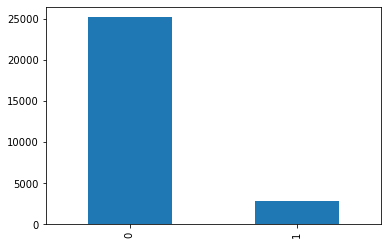

In [13]:
#종속변수 분포 확인
train['target'].value_counts().plot(kind='bar')
plt.show()

### PCA를 활용하여 차원축소

In [14]:
train_x_value = train.drop(['target'], axis=1).values # 독립변인들의 value값만 추출
train_y_value = train['target'].values # 종속변인 추출

Scaler = StandardScaler()
train_x_value = Scaler.fit_transform(train_x_value) # x객체에 x를 표준화한 데이터를 저장

features = train.columns[1:]
train_x = pd.DataFrame(train_x_value, columns=features)
train_x.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,-1.831819,0.263421,-0.436025,-1.225976,0.814515,-1.768835,0.728156,-0.629990,-0.221673,-0.201876,...,0.878994,0.203224,-1.157436,-0.854675,-0.973680,-0.744920,0.794532,0.378777,-0.527864,-0.414612
1,1.854437,0.791878,2.280252,0.269419,0.662972,1.388540,-0.678356,1.293893,0.251197,0.912113,...,0.905690,-0.022336,1.673622,0.188641,-0.205472,-0.804765,1.349836,0.147756,-0.090245,-0.721369
2,-1.834657,0.464512,1.669712,-1.541387,1.514693,-0.198249,-0.153806,-1.945621,0.685998,1.536448,...,-0.651641,-0.061447,-0.918572,1.209584,0.496465,0.402342,-1.068425,-0.290902,1.456700,1.396228
3,-0.739059,-0.050005,-0.994440,-0.685440,-0.831883,-1.637577,-1.518447,-0.365534,0.489566,-0.382233,...,0.913577,1.274970,1.261918,-0.828404,-0.546699,0.201354,1.216963,0.596049,1.189036,-0.181300
4,-0.787863,-1.007165,0.740300,0.241081,0.802379,-0.351776,1.522788,0.551004,-0.911688,0.172418,...,1.779050,-0.515459,-0.868783,0.418755,1.058576,-1.956818,0.637095,0.682655,0.659134,-0.003311


In [15]:
pca = PCA()
pca_array = pca.fit_transform(train_x)
pca_df = pd.DataFrame(pca_array, index=train_x.index,
                      columns=[f"PC{num+1}" for num in range(train_x.shape[1])])
result = pd.DataFrame({'설명가능한 분산 비율(고윳값)':pca.explained_variance_,
             '기여율':pca.explained_variance_ratio_},
            index=np.array([f"pca{num+1}" for num in range(train_x.shape[1])]))
result['누적기여율'] = result['기여율'].cumsum()
result.iloc[48:,]

,설명가능한 분산 비율(고윳값),기여율,누적기여율
pca49,1.069052,0.005345,0.272927
pca50,1.067343,0.005337,0.278263
pca51,1.066219,0.005331,0.283594
pca52,1.063839,0.005319,0.288913
pca53,1.062787,0.005314,0.294227
...,...,...,...
pca196,0.854112,0.004270,0.983074
pca197,0.850501,0.004252,0.987326
pca198,0.847656,0.004238,0.991564
pca199,0.845613,0.004228,0.995792


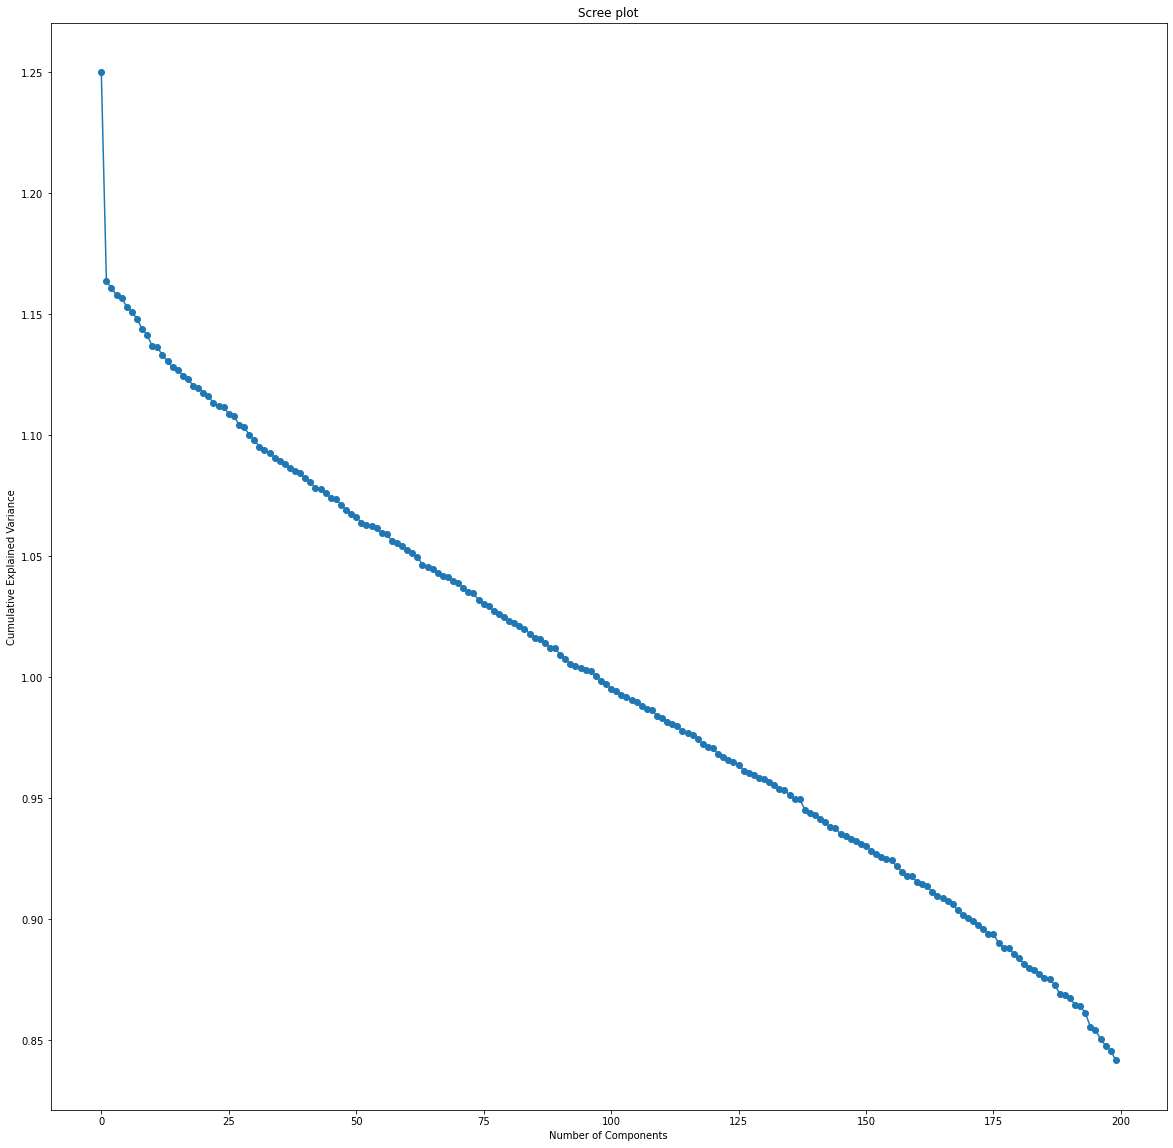

In [16]:
plt.figure(figsize=(20,20))
plt.title("Scree plot")
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.plot(pca.explained_variance_,'o-')

In [17]:
pca = PCA(n_components=50) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(train_x)
train_pca = pd.DataFrame(data=printcipalComponents, 
                           columns=[f"PC{num+1}" for num in range(50)])
train_pca.head(10)
# 주성분으로 이루어진 데이터 프레임 구성

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
0,0.284570,-1.175164,-0.597109,-1.055568,2.203811,0.638218,0.355356,-0.533368,1.310182,0.726493,...,-0.388543,0.773135,0.169809,-2.142467,-0.175921,0.417299,2.527995,-0.444014,0.137424,-1.352698
1,1.581375,0.214378,-0.586744,-0.304077,0.997588,0.097308,0.524792,0.373781,-0.215670,1.562333,...,-0.604800,-1.217851,0.961508,-1.174410,0.609647,0.147910,-1.067572,-1.498020,-1.683428,0.238755
2,-1.295062,-0.286716,-0.009559,0.030682,-0.073629,0.015831,0.496527,-1.713772,-0.026425,0.577822,...,-0.116330,-0.232884,-0.981372,-1.107298,0.381297,-0.421201,0.558460,-0.101975,0.738630,1.347404
3,-0.042755,-0.083079,0.035062,0.182861,-0.070343,-3.264221,1.017430,0.461008,0.578900,0.864562,...,-1.251816,-0.914680,-0.451738,0.794980,-0.746523,-0.271542,-0.537695,0.721626,-1.234441,1.910676
4,-0.330191,-1.252947,0.587770,-0.345760,0.579768,-0.129936,0.068158,0.104588,0.886114,-2.383402,...,-1.328858,-0.005912,0.920117,1.426707,0.944114,0.116332,2.436213,-1.363459,-0.336847,-1.917983
5,-1.500117,-0.550925,0.480230,-0.359418,-1.048080,0.611936,-1.919722,1.774277,-0.544187,1.442846,...,-0.550080,-0.080188,-0.224310,0.001216,-0.038394,0.124479,0.552401,0.093006,-1.275302,-0.964965
6,-0.132042,0.180827,-1.818890,0.511139,0.171290,1.093055,-0.112929,0.746351,-0.098019,-1.018327,...,1.083456,-1.221491,1.644273,1.163481,1.582452,-0.878268,-0.307799,-1.033735,-1.161812,-1.368525
7,0.474057,-1.562999,-2.096950,0.401755,1.754806,0.848403,-2.124988,0.681575,-0.185159,0.913076,...,1.104738,0.028597,-0.008521,0.045414,0.998554,-0.592678,-0.252680,-0.189914,0.182490,-0.896975
8,-0.425586,1.785442,-1.238104,0.826349,-0.919006,-1.218102,-0.490867,-0.944013,-0.542426,-0.114084,...,1.306093,-0.577060,0.080865,-0.767315,0.890025,1.255097,0.710481,0.471621,-0.665361,-0.111778
9,-2.439308,1.385954,1.329760,1.568595,-0.820271,0.462384,-1.106245,0.147579,1.008987,1.449976,...,-0.672168,-0.841483,0.051605,-0.251405,-0.296951,0.238374,-1.609209,1.653758,1.908265,-1.477634


In [18]:
#누적기여율 확인
sum(pca.explained_variance_ratio_)

0.263721725038093

## 2. 모델링

In [19]:
from lightgbm import LGBMClassifier

In [20]:
train_y = train_y_value

In [21]:
#validation셋 분리
X_train, X_val, y_train, y_val= train_test_split(train_pca, train_y, test_size = 0.2, 
                                                 random_state = 990706)

In [22]:
#하이퍼파라미터 튜닝
#여기는 제출 안하셔도 됩니다!
tic = time.time()

params = {
    'max_depth':[20, 30, 40],
    'min_child_samples':[60,100],
    'subsample':[0.6, 0.8],
    'learning_rate':[0.01],
    'colsample_bytree':[0.7, 0.8],
    'num_leaves' : [30, 40],
    'scale_pos_weight' : [0.6, 0.8, 1]
    
}
lgbm = LGBMClassifier(n_estimators = 1000, random_state = 990706)

gridcv = GridSearchCV(lgbm, param_grid = params)
gridcv.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = 'logloss',
          eval_set = [(X_train, y_train), (X_val, y_val)], verbose=False)

lgbm_f1 = f1_score(y_val, gridcv.predict(X_val))

toc = time.time()

print('Optimized hyperparameters', gridcv.best_params_) 
print('f1 Score: {0:.4f}'.format(lgbm_f1))
print('튜닝시간:', toc - tic)

Optimized hyperparameters {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 20, 'min_child_samples': 100, 'num_leaves': 40, 'scale_pos_weight': 1, 'subsample': 0.6}
f1 Score: 0.2235
튜닝시간: 1433.935200214386


In [23]:
#최적 파라미터
gridcv.best_estimator_

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.01, max_depth=20,
               min_child_samples=100, n_estimators=1000, num_leaves=40,
               random_state=990706, scale_pos_weight=1, subsample=0.6)

## 3. Predict

In [147]:
#Test데이터 불러오기
test= pd.read_csv("C:/Users/User/Desktop/2021여름 방학세미나/data/test.csv")

In [148]:
#test PCA 변환
test_x = Scaler.transform(test) # x객체에 x를 표준화한 데이터를 저장
features = test.columns
test_x = pd.DataFrame(test_x, columns=features)
test_x.head()

printcipalComponents = pca.transform(test_x)
test_pca = pd.DataFrame(data=printcipalComponents, 
                           columns=[f"PC{num+1}" for num in range(50)])
test_pca.head(10)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
0,0.310255,-1.239798,-1.575807,-0.360159,-2.632143,-1.106203,-2.805719,0.605699,-1.339198,0.624553,...,-0.897172,0.767665,1.806010,-0.153205,1.186340,-0.710526,-0.453556,-0.338803,-1.169804,1.322731
1,-0.414448,-0.850918,-0.308188,1.462823,-0.698345,-0.075422,0.835762,0.229135,0.738076,-0.858143,...,-0.681450,1.130964,-0.029552,2.152470,-0.126253,-0.845212,0.194714,-0.736738,0.592569,-0.419104
2,0.747430,0.030034,-1.289212,0.089361,0.006254,-1.360430,-1.136789,-0.292039,-0.986582,-0.295561,...,-0.497297,0.427095,1.829442,1.004134,-1.375494,1.257911,2.250192,-1.249208,0.701109,1.792063
3,0.964816,-0.590543,0.099212,1.050213,1.717731,-0.819067,2.779799,0.026118,0.146554,0.518279,...,0.994055,3.329295,-0.777745,-0.248937,-0.966911,-0.503569,1.131375,-0.605475,-0.352702,1.329497
4,-0.443250,-0.956352,-1.706137,-0.979791,-0.083164,-1.451373,1.400083,0.080366,-0.367586,0.001638,...,0.672838,0.567198,-0.722561,1.326401,0.292473,1.241851,1.718935,0.140565,0.375795,0.669963
5,-1.449469,0.116817,0.834342,0.847430,-1.780817,0.690803,-0.491056,-0.919008,-3.061126,0.202422,...,0.211942,-1.634819,-0.331464,1.690054,0.896121,0.235371,0.103123,0.994395,-0.100267,-0.751950
6,0.840591,-0.261720,-1.459582,-0.689350,-2.335691,-0.853307,-0.260916,0.799322,0.813228,-0.394693,...,-2.276022,0.315786,-1.327762,0.272617,0.129430,0.980948,0.096939,2.362404,0.222061,-0.541599
7,-0.289431,0.950808,-0.388620,-0.300029,-1.123502,0.491281,0.729452,0.624884,1.470136,-0.912320,...,-0.469130,1.919164,0.751590,1.367353,1.211505,0.608683,-0.701141,-0.775093,-0.173075,0.276636
8,0.936938,-0.833659,-0.128384,1.716153,0.608821,-0.211703,-0.421201,-1.260553,0.732448,-0.145970,...,0.611626,-0.663387,-0.511734,1.630964,-0.873736,-0.810265,0.750999,-0.843371,-2.207819,0.385716
9,-1.302961,-0.052280,-1.059729,-0.926527,2.314430,-0.524081,0.787650,-0.774363,-0.783896,0.888847,...,0.899594,2.177181,1.472470,-0.754776,-1.868532,0.166000,-0.865082,2.200805,-2.000135,-0.143989


In [149]:
#최적파라미터 확인
gridcv.best_estimator_

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.01, max_depth=20,
               min_child_samples=100, n_estimators=1000, num_leaves=40,
               random_state=990706, scale_pos_weight=1, subsample=0.6)

In [197]:
#튜닝된 파라미터로 재학습

tic = time.time()

lgbm_best = gridcv.best_estimator_
'''lgbm_best = LGBMClassifier(n_estimators = 1000,
                           colsample_bytree=0.8, 
                           learning_rate=0.01, 
                           max_depth=20,
                           min_child_samples=100, 
                           num_leaves=40,
                           random_state=990706, 
                           scale_pos_weight=1, 
                           subsample=0.6)'''

lgbm_best.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = 'logloss',
          eval_set = [(X_train, y_train), (X_val, y_val)], verbose=False)

#예측
pred = lgbm_best.predict(test_pca)
toc = time.time()

print('학습 시간:', toc - tic)

학습 시간: 1.8680546283721924


In [198]:
#예측값 분포 확인
print(list(pred).count(1))
print(list(pred).count(0))

28
1972


In [199]:
#데이터셋 저장
pred = pd.DataFrame(pred)
id1 = pd.DataFrame(range(1, 2001))
pred_y = pd.concat([id1, pred], axis = 1)
pred_y.columns = ['id','target']
pred_y.to_csv("C:/Users/User/Desktop/2021여름 방학세미나/data/pred_y_3.csv",index = False)